In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from functools import reduce

from scipy.interpolate import griddata
import matplotlib.colors as colors

import numpy as np
import DataPreprocessing
import SmartPolynomials
import SplitDataSet

Using TensorFlow backend.


In [2]:
!pip install -q pyyaml h5py

In [24]:
def build_model(components=150, momentum=0.9, learning_rate=0.02, activation='relu', hidden_layers=1):
    model = keras.Sequential([
        keras.layers.Dense(components, activation=activation, input_shape=[8]), #could try swish??  

        keras.layers.Dense(components + 1, activation=activation),
        keras.layers.Dense(components + 2, activation=activation),
        #keras.layers.Dense(components + 3, activation=activation),
        #*[keras.layers.Dense(components + 1, activation=activation)]*hidden_layers,
      
        keras.layers.Dense(1, activation='linear') 
    ])

    #learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0006, 250, 50)
    sgd=tf.keras.optimizers.SGD(learning_rate, momentum=momentum, nesterov=True)
    #adam = tf.keras.optimizers.Nadam()
    #print(adam.get_config())
    model.compile(loss='mse', 
                optimizer=sgd, metrics=['mape'])
    return model

In [34]:
def decay(epoch):
  if epoch < 5:
    return 7e-7
  elif epoch >= 5 and epoch < 10:
    return 3e-7
  else:
    return 1e-7


In [35]:
def calc_RMSE(mom_train, mom_test, temp_train, temp_test, var_name):
    model = build_model()
    scaler = StandardScaler()

    poly_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train[:,1:]])
    poly_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test[:,1:]])
    poly_train = scaler.fit_transform(poly_train) #Rescale on training set
    poly_test = scaler.transform(poly_test)

        # Saves the best model's weights
    checkpoint_path = "NLO/MODEL/uuxg_{epoch:04d}.hdf5"
    callback_a = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)
    callback_b = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    callback_c = tf.keras.callbacks.LearningRateScheduler(decay)
    history = model.fit(poly_train, temp_train, batch_size=32, epochs=50, 
                        shuffle=True, verbose=1, callbacks=[callback_b, callback_a, callback_c], validation_split=0.2)


    try:
        # load the saved model
        saved_model = build_model()
        saved_model.load_weights(checkpoint_path)

        # evaluate the model
        _, train_error = saved_model.evaluate(poly_train, temp_train, verbose=0)
        _, test_error = saved_model.evaluate(poly_test, temp_test, verbose=0)
        print('Train: %.3f, Test: %.3f' % (train_error, test_error))
        
        me_predict = saved_model.predict(poly_test, verbose=0) #Prediction on test set
        me_predict.shape = (len(me_predict))
        
        return(train_error, test_error, np.abs(np.divide(temp_test - me_predict, temp_test)), history)
    
    except ValueError:
        print('Value Error Encountered')       
        return(0, 0, 0, 0)

In [36]:
def sqrt(me):
    return np.multiply(np.sign(me), np.power(abs(me), 0.5))

In [37]:
train, test, perc = 0, 0, 0

##Obtain & process data NPY
#me_train, mom_train = DataPreprocessing.npy('NLO/MG_uuxg/me_1000000.npy', 'NLO/MG_uuxg/mom_1000000.npy', [], frac=1)
#me_test, mom_test = DataPreprocessing.npy('NLO/MG_uuxg/me_100000.npy', 'NLO/MG_uuxg/mom_100000.npy', [], frac=1)

me_train, mom_train = SplitDataSet.smallestS('NLO/MG_uuxg/me_4000000.npy', 'NLO/MG_uuxg/mom_4000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('NLO/MG_uuxg/me_1000000.npy', 'NLO/MG_uuxg/mom_1000000.npy', 1)

print(me_train.shape)
for i, name in enumerate(['Real']):
    i += 1
    div_train = reduce(np.multiply, np.square(DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train)))
    div_test = reduce(np.multiply, np.square(DataPreprocessing.mandel_creation(['1,3','2,3'], mom_test)))
    
    temp_train = np.multiply(div_train, me_train)
    temp_test = np.multiply(div_test, me_test)
    
    #div_train = reduce(np.multiply, 1000-DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train))
    #div_test = reduce(np.multiply, 1000-DataPreprocessing.mandel_creation(['1,3','2,3'], mom_test))
    
    #temp_train = np.multiply(div_train, temp_train)
    #temp_test = np.multiply(div_test, temp_test)
    
    if i == 1 or i == 2:
        #pyplot.scatter(DataPreprocessing.mandel_creation(['2,3'], mom_test)[0].T, rescaled_test)
        #pyplot.show()
        temp_train = sqrt(temp_train)
        temp_test = sqrt(temp_test)
        
        print('Std : {}'.format(np.std(temp_train)))
        print('Mean : {}'.format(np.mean(temp_train)))
        train, test, perc, history = calc_RMSE(mom_train, mom_test, temp_train, temp_test, name)

(1332949,)
Std : 443.52931441083666
Mean : 182.94190619087658
Train on 1066359 samples, validate on 266590 samples
Epoch 1/50
1066359/1066359 [==============================]1066359/1066359 [==============================] - 69s 65us/step - loss: 2255.0218 - mean_absolute_percentage_error: 7.8284 - val_loss: 129.3319 - val_mean_absolute_percentage_error: 3.7869

Epoch 2/50
1066359/1066359 [==============================]1066359/1066359 [==============================] - 69s 65us/step - loss: 121.0052 - mean_absolute_percentage_error: 3.6834 - val_loss: 73.8787 - val_mean_absolute_percentage_error: 2.7920

Epoch 3/50
1066359/1066359 [==============================]1066359/1066359 [==============================] - 70s 65us/step - loss: 83.8313 - mean_absolute_percentage_error: 3.0844 - val_loss: 52.6955 - val_mean_absolute_percentage_error: 2.4352

Epoch 4/50
1066359/1066359 [==============================]1066359/1066359 [==============================] - 72s 68us/step - loss: 65.6182 

1066359/1066359 [==============================]1066359/1066359 [==============================] - 74s 69us/step - loss: 14.9071 - mean_absolute_percentage_error: 1.3349 - val_loss: 16.4007 - val_mean_absolute_percentage_error: 1.4080

Epoch 34/50
1066359/1066359 [==============================]1066359/1066359 [==============================] - 74s 70us/step - loss: 14.7499 - mean_absolute_percentage_error: 1.3262 - val_loss: 15.4384 - val_mean_absolute_percentage_error: 1.3677

Epoch 35/50
1066359/1066359 [==============================]1066359/1066359 [==============================] - 74s 69us/step - loss: 14.5878 - mean_absolute_percentage_error: 1.3193 - val_loss: 13.8788 - val_mean_absolute_percentage_error: 1.2919

Epoch 36/50
1066359/1066359 [==============================]1066359/1066359 [==============================] - 74s 69us/step - loss: 14.4025 - mean_absolute_percentage_error: 1.3149 - val_loss: 14.3004 - val_mean_absolute_percentage_error: 1.3207

Epoch 37/50
1066359/

OSError: Unable to open file (unable to open file: name = 'NLO/MODEL/uuxg_{epoch:04d}.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [38]:
points = len(history.history['loss'])
pyplot.plot(range(points), history.history['loss'], color='r', label='Training Set')
pyplot.plot(range(points), history.history['val_loss'],color='b', label='Val Set')
pyplot.legend()
#pyplot.ylim(0, 0.0002)
pyplot.yscale('log')

NameError: name 'history' is not defined

2 Layers 500 components min ~ 0.05 mse and 10% error.
Reduced layers by 1 and added 500 components. 

[-0.06546281, -0.06963603, -0.07153936, -0.07195645, -0.07246053, -0.07289584, -0.07332222, -0.07337598, -0.073417105, -0.07346608, -0.07350466, -0.07354919, -0.07358666, -0.0736283, -0.073664, -0.07371218, -0.07374824, -0.073786244, -0.0738274, -0.07387225, -0.073913746, -0.073942475, -0.07398209, -0.07402562, -0.0740638, -0.07410027, -0.074135825, -0.07417442, -0.07421247, -0.074252166, -0.074286476, -0.074322306, -0.07436175, -0.074391164, -0.07442833, -0.074467085, -0.0745019, -0.07453755, -0.074568294, -0.07460394, -0.07464056, -0.07467186, -0.07471128, -0.07474019, -0.07478287, -0.07481857, -0.07483905, -0.074881226, -0.074910775, -0.07493908]


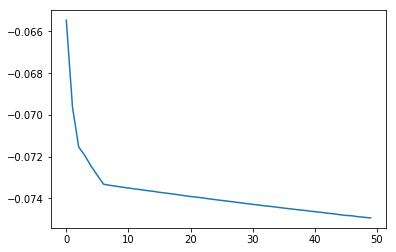

In [29]:
weights = []

for i in range(50):
    saved_model = build_model()
    saved_model.load_weights("NLO/MODEL/uuxg_{:04d}.hdf5".format(i+1))
    weights.append(np.array(saved_model.get_weights()[4])[1,10])
    
print(weights)

pyplot.plot(weights)

TypeError: 'Variable' object is not iterable.

In [51]:
print(me_predict)

NameError: name 'me_predict' is not defined

###### 60% error for temp
Scaled by log 0.04469647411690197

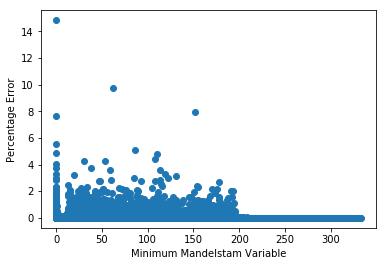

In [13]:
mandel_str = ['1,3','2,3','1,2']
def error_smallest_S(perc_error, mom):
    mandel_vars = DataPreprocessing.mandel_creation(mandel_str, mom)
    min_mandel_vars = [min(mandel_var) for mandel_var in mandel_vars.T]
    #print(sum([1 for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 175000]))
    #print(100*np.mean([perc_error[i] for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 100]))
    pyplot.scatter(min_mandel_vars,perc_error)
    pyplot.xlabel('Minimum Mandelstam Variable')
    pyplot.ylabel('Percentage Error')
    #pyplot.ylim(0,0.03)
    
error_smallest_S(perc, mom_test)

In [14]:
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test)

x1 = np.divide(s12, 1000)
x2 = np.divide(s13, 1000)
x3 = np.divide(s23, 1000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [15]:
#Value at grid coordinate is mapped to the nearest actual datapoint.
print(len(perc))
grid = griddata((x2, x3), np.abs(perc), (X2i, X3i), method='nearest')
print(grid)

332588
[[4.89418947e+00 8.69597351e-01 1.62989658e-01 ... 1.50192458e-03
  1.50192458e-03 1.50192458e-03]
 [5.25991237e-01 1.62989658e-01 2.04731962e-02 ... 1.50192458e-03
  1.50192458e-03 1.50192458e-03]
 [5.86744063e-01 1.92041275e-01 2.04731962e-02 ... 1.50192458e-03
  1.50192458e-03 1.50192458e-03]
 ...
 [1.93415217e-01 5.55967399e-02 5.55967399e-02 ... 1.96888541e-04
  1.96888541e-04 1.96888541e-04]
 [7.44615115e-01 1.02704562e-01 1.02704562e-01 ... 3.05415654e-03
  3.05415654e-03 1.96888541e-04]
 [2.34758640e-02 2.34758640e-02 1.02704562e-01 ... 3.05415654e-03
  3.05415654e-03 3.05415654e-03]]


Text(0.5,0,'S_23')

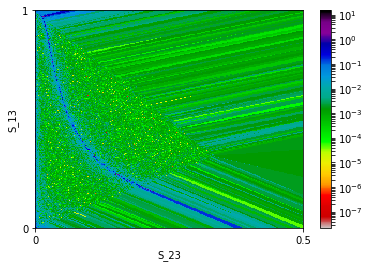

In [16]:
fig, ax = pyplot.subplots()
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
#cbar.set_label('Percentage Error')

ax.set_xticks([0, 250])
ax.set_xticklabels([0, 0.5])
ax.set_xlim(0,250)
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('S_13')
ax.set_xlabel('S_23')